## 加载类库

In [1]:
import os
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator

/Users/kevin/anaconda2/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 获得当前目录
current_dir = os.getcwd()
np.random.seed(2018)

## 导入模型

In [3]:
X_train = []
X_test = []
# 聚合模型
for filename in ["feature_resnet50.h5", "feature_xception.h5", "feature_inception_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

In [4]:
from sklearn.model_selection import train_test_split
labels = np.array([0] * 12500 + [1] * 12500)
X_train, X_val, y_train, y_val = train_test_split(X_train, labels, shuffle=True, test_size=0.2, random_state=20)

## 构建模型

In [5]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

## 模型可视化

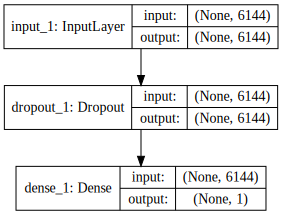

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 训练

每次epoch保存较好的模型权重进行下一步的训练

In [6]:
from keras.callbacks import ModelCheckpoint
saveWeightName = "merge_fine_weight.h5"
checkpoint = ModelCheckpoint(filepath="fine_weight.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min',
                             save_weights_only=True)

model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True, callbacks=[checkpoint])
model.save_weights(saveWeightName)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 1s 43us/step - loss: 0.0994 - acc: 0.9653 - val_loss: 0.0256 - val_acc: 0.9942

Epoch 00001: val_loss improved from inf to 0.02555, saving model to fine_weight.h5
Epoch 2/20
16000/16000 [==============================] - 1s 36us/step - loss: 0.0257 - acc: 0.9919 - val_loss: 0.0207 - val_acc: 0.9935

Epoch 00002: val_loss improved from 0.02555 to 0.02074, saving model to fine_weight.h5
Epoch 3/20
16000/16000 [==============================] - 1s 35us/step - loss: 0.0190 - acc: 0.9940 - val_loss: 0.0167 - val_acc: 0.9955

Epoch 00003: val_loss improved from 0.02074 to 0.01667, saving model to fine_weight.h5
Epoch 4/20
16000/16000 [==============================] - 1s 34us/step - loss: 0.0168 - acc: 0.9946 - val_loss: 0.0169 - val_acc: 0.9950

Epoch 00004: val_loss did not improve from 0.01667
Epoch 5/20
16000/16000 [==============================] - 1s 36us/step - loss: 0.0142 - acc

In [7]:
# 模型预测
model.load_weights(saveWeightName)
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 19us/step


## 测试集预测

In [8]:
df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + "/data/test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/') + 1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('merged_pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/Users/kevin/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


0.03936

Found 12500 images belonging to 1 classes.


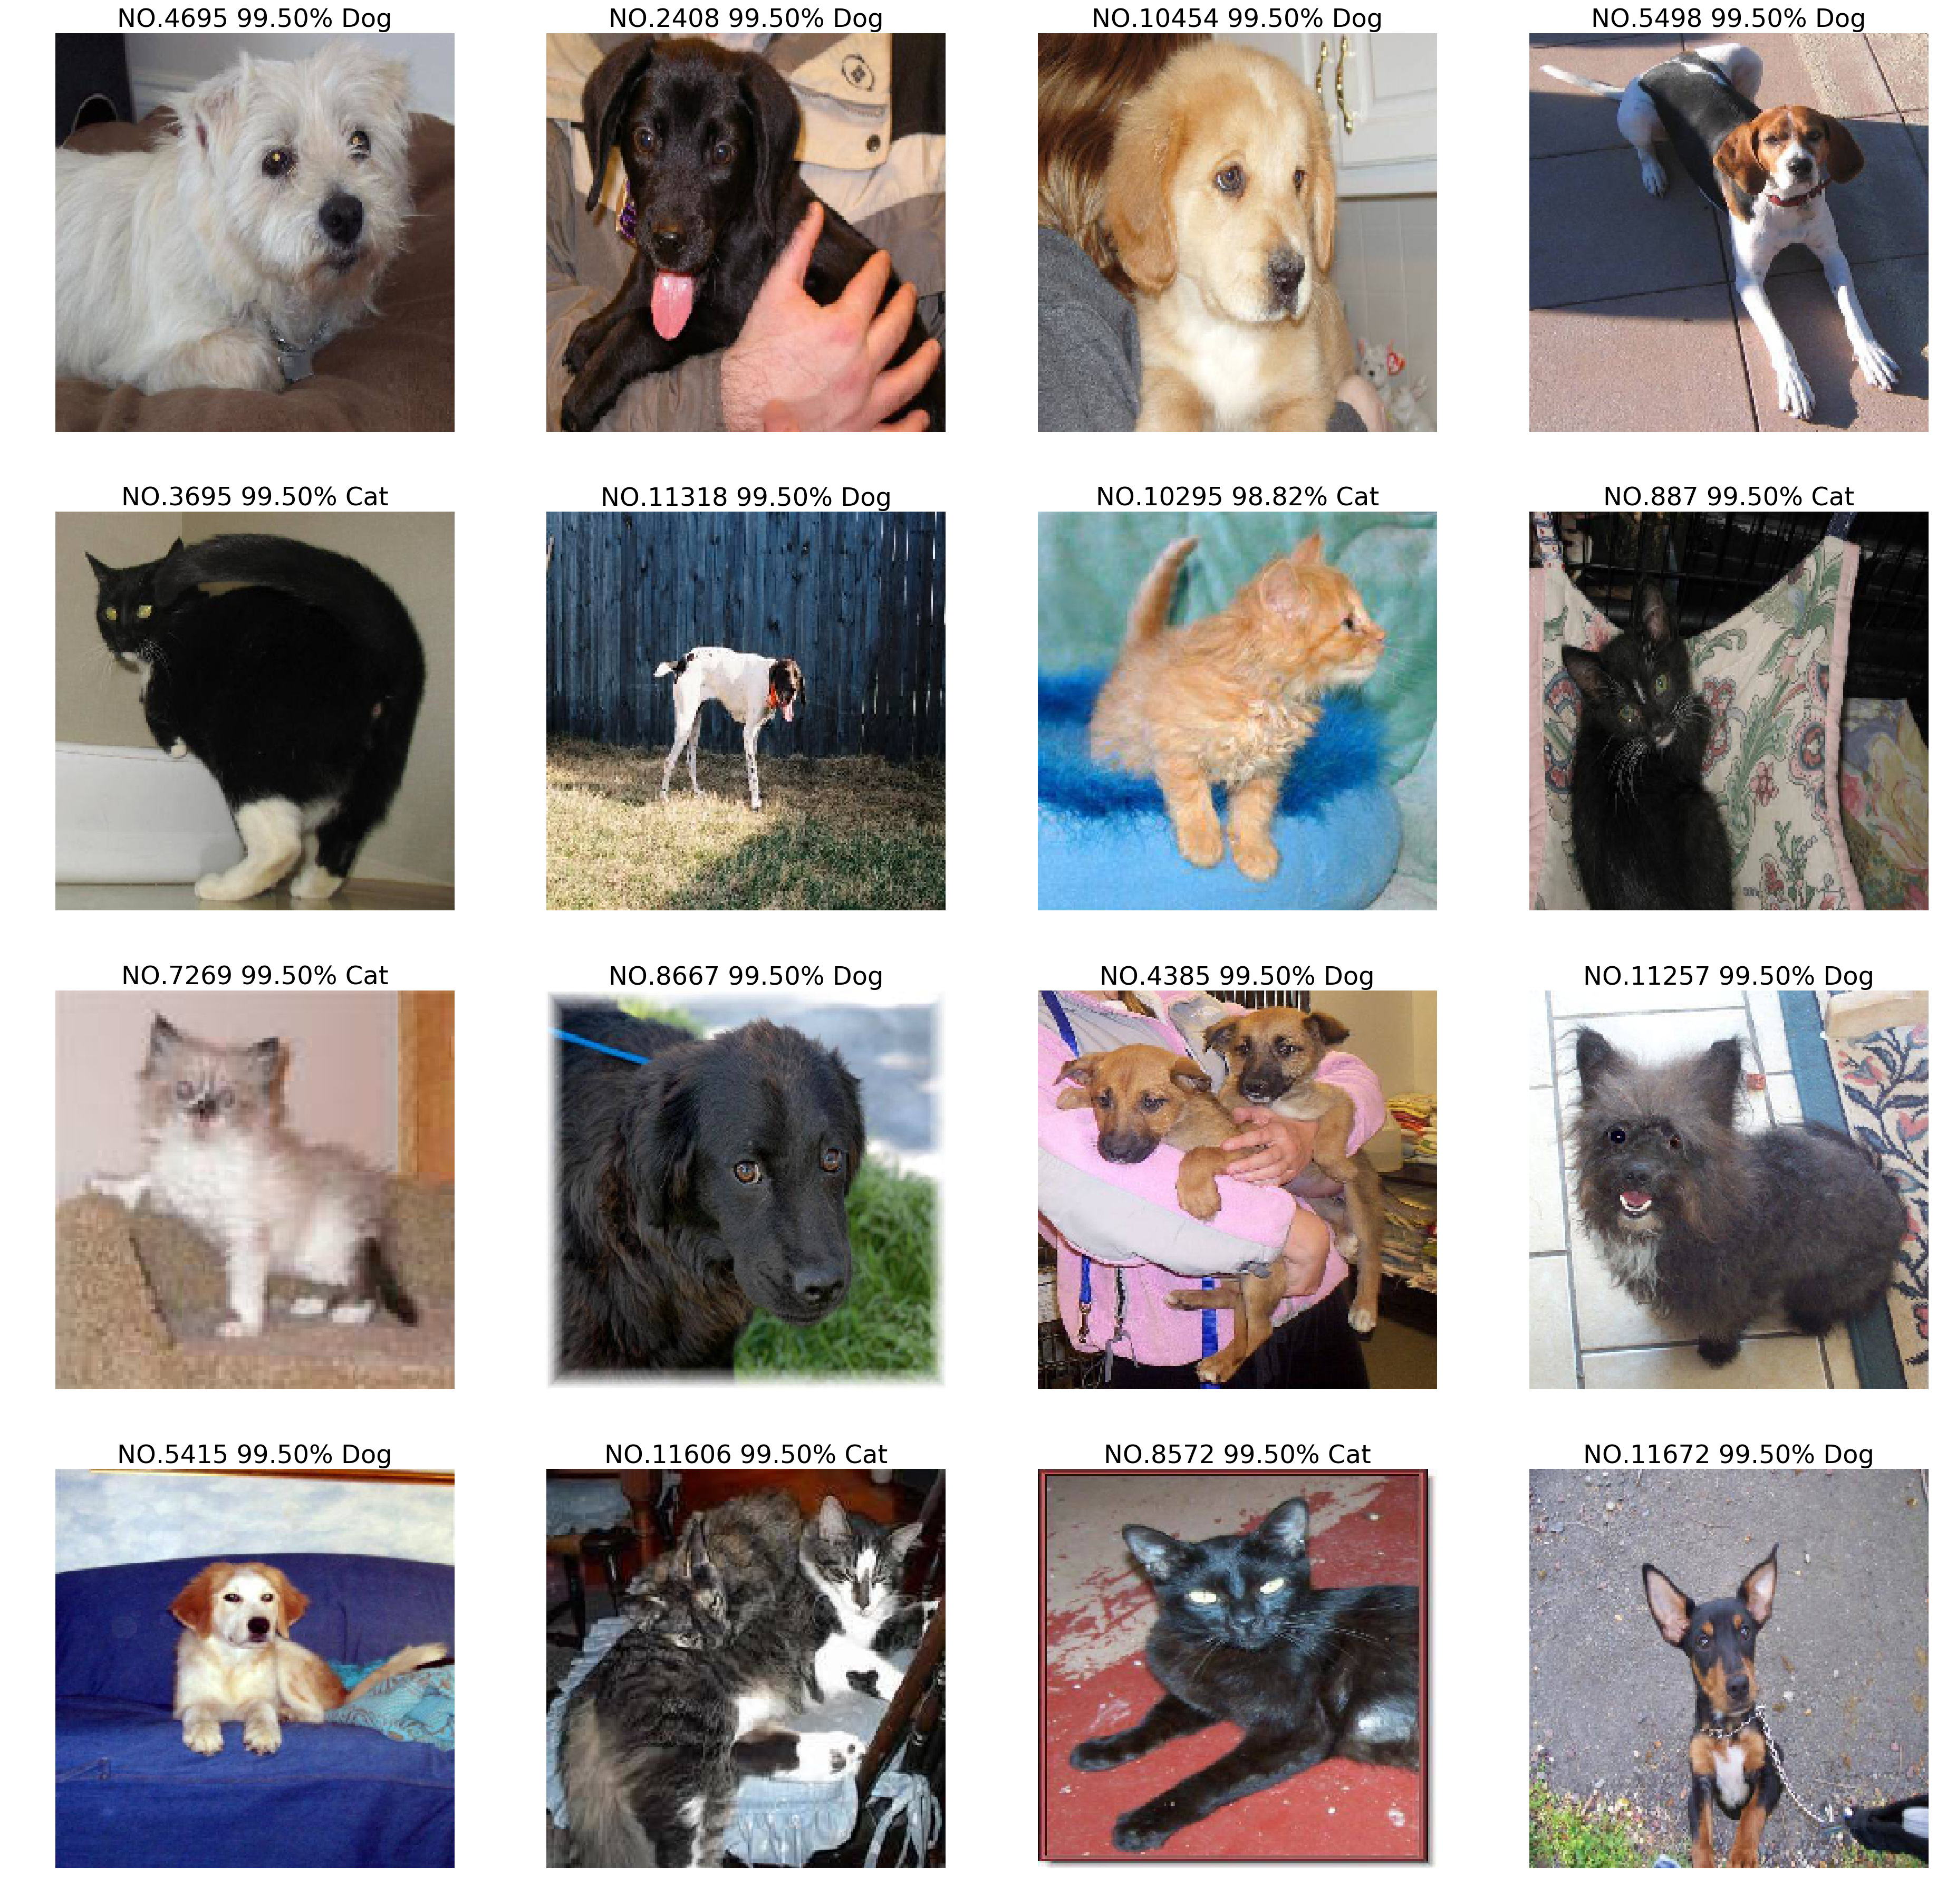

In [53]:
from PIL import Image

row, col = 4, 4

figure, ax = plt.subplots(row, col, sharex=True, sharey=True)
plt.rc('figure', figsize=(32,32))
font_option={'size':20}
plt.rc('font',**font_option)
figure.titlesize  = "large"

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + '/data/test/', shuffle=False)
for i in range(col):
    for j in range(row):
        y_pred_index = random.randint(1, 12500)
        img_file_name = current_dir + '/data/test/' + test_generator.filenames[y_pred_index]
        img = Image.open(img_file_name)
        img = img.resize((224,224))
        # 关闭坐标轴
        ax[i][j].axis('off') 
        percent = float(y_pred[y_pred_index])
        if percent < 0.5:
            ax[i][j].set_title('NO.{} {:.2%} Cat'.format(y_pred_index, 1.0 - percent)) 
        else:
            ax[i][j].set_title('NO.{} {:.2%} Dog'.format(y_pred_index, percent)) 
        ax[i][j].imshow(img)
        
plt.savefig("samples.jpg")